In [ ]:
import autorootcwd
from src.model.model import FrozenInTime, compute_similarity
from src.data.data_loader import TextVideoDataLoader
import torch.optim as optim
import torch
from transformers import AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = TextVideoDataLoader(
    dataset_name="NTU",
    text_params={"model": "distilbert-base-uncased", "pretrained": True},
    video_params={"model": "SpaceTimeTransformer", "arch_config": "base_patch16_224", "num_frames": 4, "input_res": 224, "pretrained": True, "time_init": "zeros", "attention_style": "frozen-in-time"},
    data_dir="data/nturgbd",
    
    batch_size=8,
    )
# NTU 데이터셋으로부터
# batch_size=8로 비디오(4프레임씩) + 캡션(리스트[str]) 페어를 반환하는 DataLoader 생성

model = FrozenInTime(
    video_params={"model": "SpaceTimeTransformer", "arch_config": "base_patch16_224", "num_frames": 4, "pretrained": True, "time_init": "zeros", "attention_style": "frozen-in-time"},
    text_params={"model": "distilbert-base-uncased", "pretrained": True},
    projection_dim=256,
)
# 비디오, 텍스트 인코더와 투영 헤드를 합친 모델 인스턴스

model.to(device)

batch_sample = next(iter(train_loader))
# DataLoader에서 첫 배치만 꺼내 옴
# batch_sample 예시 구조 : 
# {
#   'video': Tensor(shape=[8,4,3,224,224]),
#   'text': List[str] length=8,
#   … (메타데이터)
# }
video_data = batch_sample['video'].to(device)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# 영문 캡션을 토크나이즈할 토크나이저 로드

text_data = tokenizer(
    batch_sample['text'],          # List[str] (배치 단위 캡션 리스트)
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length
).to(device)
# 토큰화 -> 텐서(input_ids, attention_mask 등)로 변환 및 패딩 -> 디바이스로 이동
# 결과 : text_data = {'input_ids': [8, seq_len], 'attention_mask': [8, seq_len], …}

######USING ATTENTION STYLE:  frozen-in-time


c:\Users\user\Documents\Fine-VLA\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


video_data.shape: torch.Size([8, 4, 3, 224, 224])
dtype: torch.float32


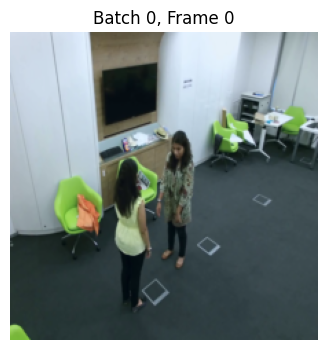

In [ ]:
import matplotlib.pyplot as plt
print("video_data.shape:", video_data.shape)
# (batch_size, num_frames, channels, height, weight)
print("dtype:", video_data.dtype)

frame = video_data[0, 0] # 배치의 첫 번째 비디오 샘플
frame = frame.permute(1, 2, 0).cpu().numpy()   
plt.figure(figsize=(4,4))
plt.title("Batch 0, Frame 0")
plt.imshow((frame - frame.min()) / (frame.max()-frame.min()))  # 정규화해서 보기
plt.axis('off')
plt.show()

In [20]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

print("batch_sample['text']:", batch_sample['text'])
print("batch_sample['text'] type:", type(batch_sample['text']))
print("batch_sample['text'] length:", len(batch_sample['text']))

text_data = tokenizer(
    batch_sample['text'],          # List[str] (배치 단위 캡션 리스트)
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=tokenizer.model_max_length
).to(device)

print("text_data['input_ids'].shape:", text_data['input_ids'].shape)
print("text_data['attention_mask'].shape:", text_data['attention_mask'].shape)


print(tokenizer.batch_decode(text_data['input_ids'][:2], skip_special_tokens=True))

batch_sample['text']: ['kicking', 'reading', 'giving_object', 'giving_object', 'hugging', 'brush_hair', 'take_off_jacket', 'tear_up_paper']
batch_sample['text'] type: <class 'list'>
batch_sample['text'] length: 8
text_data['input_ids'].shape: torch.Size([8, 7])
text_data['attention_mask'].shape: torch.Size([8, 7])
['kicking', 'reading']


In [ ]:
video_embeddings = model.compute_video(video_data)
# 비디오 인코더 + 투영 헤드 통과 -> shape=[8, projection_dim] 텐서
text_embeddings = model.compute_text(text_data)
# 텍스트 인코더 + 투영 헤드 통꽈 -> shape=[8, projection_dim] 텐서

optimizer = optim.Adam(model.parameters(), lr=1e-4)

sim_matrix, _ = compute_similarity(text_embeddings, video_embeddings)
_, similarity_loss = compute_similarity(video_embeddings, text_embeddings)

optimizer.zero_grad()
loss = -similarity_loss.mean()
loss.backward()
optimizer.step()

print(f"loss: {loss.item():.4f}")

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

all_embeddings = torch.cat([video_embeddings, text_embeddings], dim=0).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(12, 10))

video_labels = 

video_count = len(video_labels)
plt.scatter(
    embeddings_2d[:video_count, 0],
    embeddings_2d[:video_count, 1],
    c='blue',
    marker='o',
    label='비디오'
)

plt.scatter(
    embeddings_2d[video_count:, 0],
    embeddings_2d[video_count:, 1],
    c='red',
    marker='^',
    label='텍스트'
)

for i, (x, y, label) in enumerate(zip(embeddings_2d[:, 0], embeddings_2d[:, 1], all_labels)):
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center'
    )

plt.title('비디오와 텍스트 임베딩의 t-SNE 시각화')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

for epoch in range(5):
    loss_epoch = 0.0
    for batch_sample in train_loader:
        video_embeddings = model.compute_video(batch_sample['video']).cuda()
        text_embeddings = model.compute_text(batch_sample['text']).cuda()

        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        similarity_loss = model.compute_similarity(video_embeddings, text_embeddings)
        optimizer.zero_grad()
        similarity_loss.backward()
        optimizer.step()
        loss_epoch += similarity_loss.item()

    loss_epoch /= len(train_loader)

    print(f'loss at epoch{epoch}:', loss_epoch)

In [ ]:
custom_texts = [
    "drink_water",
    "eat_meal",
    "brush_teeth",
    "brush_hair",
    "drop",
    "pickup",
    "throw",
    "sit_down",
    "stand_up",
    "clapping",
    "reading",
    "writing",
    "hand_waving"
]

In [ ]:
# 테스트 데이터 준비
sample_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
test_videos = []
test_texts = []

# 테스트 데이터 샘플 수집
with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        if i >= len(train_loader.dataset):
            break
        sample = train_loader.dataset[idx]
        
        # 비디오 임베딩 계산
        video = sample['video'].unsqueeze(0).to(device)
        test_videos.append(video)
        
    # 텍스트 임베딩 계산
    text_inputs = []
    for text in custom_texts:
        text_input = train_loader.dataset.tokenize([text])
        text_input = {k: v.to(device) for k, v in text_input.items()}
        text_inputs.append(text_input)

    # 임베딩 계산
    video_embeddings = torch.cat([model.compute_video(video) for video in test_videos], dim=0)
    text_embeddings = torch.stack([model.compute_text(text_input) for text_input in text_inputs], dim=0)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 임베딩 결합 및 NumPy 변환
all_embeddings = torch.cat([video_embeddings, text_embeddings], dim=0).cpu().numpy()

# 라벨 준비
video_labels = [f"비디오 {i}" for i in sample_indices[:len(test_videos)]]
text_labels = custom_texts
all_labels = video_labels + text_labels

# t-SNE 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(12, 10))

video_count = len(video_labels)
plt.scatter(
    embeddings_2d[:video_count, 0],
    embeddings_2d[:video_count, 1],
    c='blue',
    marker='o',
    label='비디오'
)

plt.scatter(
    embeddings_2d[video_count:, 0],
    embeddings_2d[video_count:, 1],
    c='red',
    marker='^',
    label='텍스트'
)

for i, (x, y, label) in enumerate(zip(embeddings_2d[:, 0], embeddings_2d[:, 1], all_labels)):
    plt.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center'
    )

plt.title('비디오와 텍스트 임베딩의 t-SNE 시각화')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 유사도 행렬 계산 및 시각화
similarity_matrix = torch.mm(video_embeddings, text_embeddings.t()).cpu().numpy()

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis')
plt.colorbar(label='코사인 유사도')
plt.xticks(np.arange(len(text_labels)), text_labels, rotation=45, ha='right')
plt.yticks(np.arange(len(video_labels)), video_labels)
plt.title('비디오-텍스트 유사도 행렬')
plt.tight_layout()
plt.show()